# Rat Sightings Data Cleaning

This notebook cleans the data in scr/data/rat_sightings_data/Rat_Sightings_NYC.csv and saves the results to sc/data/Rat_Sightings_Cleaned.csv. The main steps of our cleaning process is summaried here.

1. We first cleaned up the column names by making words lowercase and replacing spaces by underscores.

2. We updated all entries in the data which are dates to pandas datetime format.

3. We dropped columns with only 1 unique value since they provide no information for later analysis.

4. We cleaned up the values of the location_type columns by shortening the strings. We used a dictionary and a mapping to keep track of the changes.

5. We consolidated redundant columns such as park_borough being the same as borough.

6. We checked that the location column was redundant due to the prescence of the latitude and longitude column. Then, we dropped the location column.

7. The rat sightings data includes information on when the case was opened and closed. We added a column which tracks the number of days it took to close each case. Doing this, we found two entries with a close date occuring before the open date.

8. The incident_zip column contains the value 12345 which does not correspond to a zip code in NYC. We update the incident_zip by using the latitude and longitude columns. 

9. We save the cleaned data to a new csv file for later use. At the end, we quantified the missingness of the data using missingno's matrix and heatmap.

10. For the purposes of this project, we then stored .csv files which contains the number of rat sightings based on time intervals and location type. For example, daily_borough_rs.csv stores the number of rat sightings seen daily and has information on which borough the rat was sighted in. As a second example, weekly_zip_rs.csv stores the weekly number of rat sightings and has information on which zip code the rat was sighted in.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [7]:
rat_sighting = pd.read_csv("../data/rat_sightings_data/Rat_Sightings_NYC.csv")
rat_sighting.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Problem (formerly Complaint Type)',
       'Problem Detail (formerly Descriptor)', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Action Updated Date', 'Community Board', 'Borough',
       'X Coordinate (State Plane)', 'Y Coordinate (State Plane)',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='str')

In [4]:
# make letters lowercase, replace spaces with underscores, get rid of text after '(' etc

rat_sighting.columns = [t.partition('(')[0].strip().lower().replace(' ', '_') for t in rat_sighting.columns] #apply to column headers
rat_sighting['location_type'] = rat_sighting['location_type'].str.strip().str.replace(' ', '_').str.lower()  #apply to location_type column

In [5]:
# identify columns with only 1 unique value (including NaNs)
cols_to_drop = [c for c in rat_sighting.columns if (rat_sighting[c].nunique(dropna=False) == 1)]

# Drop them all in one go
rat_sighting = rat_sighting.drop(columns=cols_to_drop)

In [6]:
# make the datetime the correct format
rat_sighting['created_date'] = pd.to_datetime(rat_sighting['created_date']) 
rat_sighting['closed_date'] = pd.to_datetime(rat_sighting['closed_date'])
rat_sighting['resolution_action_updated_date'] = pd.to_datetime(rat_sighting['resolution_action_updated_date'])


/var/folders/ry/m6r2ndwd10bdv8tvww5hr2680000gn/T/ipykernel_89678/582883039.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rat_sighting['created_date'] = pd.to_datetime(rat_sighting['created_date'])
/var/folders/ry/m6r2ndwd10bdv8tvww5hr2680000gn/T/ipykernel_89678/582883039.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rat_sighting['resolution_action_updated_date'] = pd.to_datetime(rat_sighting['resolution_action_updated_date'])


In [7]:
rat_sighting['location_type'].value_counts()

location_type
3+_family_apt._building          63546
1-2_family_dwelling              23850
other_(explain_below)            22837
3+_family_mixed_use_building      8054
commercial_building               7314
construction_site                 2579
vacant_lot                        2509
1-2_family_mixed_use_building     2147
vacant_building                   1743
parking_lot/garage                1634
catch_basin/sewer                 1100
sidewalk                           504
public_garden                      473
street                             247
school/pre-school                  238
government_building                209
office_building                    145
3+_family_apartment_building       110
day_care/nursery                    90
single_room_occupancy_(sro)         87
hospital                            85
public_stairs                       80
street_area                         72
parking_lot_or_garage               71
residential_building                36
catch_basin

In [8]:
# Create a dictionary of the "wrong" names and the "right" name
mapping = {
    '3+_family_apartment_building': '3+_family_apt._building',
    '3+family_apt.': '3+_family_apt._building',
    '3+_family_apt.': '3+_family_apt._building',
    '3+_family_apt': '3+_family_apt._building',
    'residential_building': '3+_family_apt._building',
    'residence': '3+_family_apt._building',
    'apartment': '3+_family_apt._building',
    '1-2_familydwelling': '1-2_family_dwelling',
    'school': 'school/pre-school/nursery',
    'school/pre-school': 'school/pre-school/nursery',
    'day_care_or_nursery': 'school/pre-school/nursery',
    'day_care/nursery': 'school/pre-school/nursery',
    'street':'street_area',
    'restaurant': 'restaurant/bar/deli/bakery',
    'catch_basin_or_sewer': 'catch_basin/sewer',
    'parking_lot_or_garage': 'parking_lot/garage',
    'government_building': 'office/government_building',
    'office/government_ building': 'office/government_building',
    'other_(explain_below)': 'other'
}

# Apply the fix
rat_sighting['location_type'] = rat_sighting['location_type'].replace(mapping)

In [9]:
rat_sighting['location_type'].value_counts()

location_type
3+_family_apt._building          63729
1-2_family_dwelling              23851
other                            22849
3+_family_mixed_use_building      8054
commercial_building               7314
construction_site                 2579
vacant_lot                        2509
1-2_family_mixed_use_building     2147
vacant_building                   1743
parking_lot/garage                1705
catch_basin/sewer                 1118
sidewalk                           504
public_garden                      473
school/pre-school/nursery          341
street_area                        319
office/government_building         209
office_building                    145
single_room_occupancy_(sro)         87
hospital                            85
public_stairs                       80
restaurant/bar/deli/bakery           7
building_(non-residential)           6
summer_camp                          2
1-3_family_mixed_use_building        2
store                                1
cafeteria_-

In [10]:
# check if park_borough and borough columns are redundant
print(rat_sighting['park_borough'].equals(rat_sighting['borough']))

True


In [11]:
rat_sighting = rat_sighting.drop(columns='park_borough')

In [12]:
#notice that information from lat, lon are repeated in point

# 1. Update the mask to ensure both lat and lon are present
not_null_mask = (
    rat_sighting['location'].notnull() & 
    rat_sighting['longitude'].notnull() & 
    rat_sighting['latitude'].notnull()
)

# 2. Extract BOTH lon and lat from the POINT string
# POINT (-73.9685 40.7540) -> index 0 is lon, index 1 is lat
coords_from_point = rat_sighting['location'].str.extract(r'POINT \(([^ ]+) ([^)]+)\)').astype(float)

# 3. Check if extracted lon matches 'longitude' AND extracted lat matches 'latitude'
lon_matches = np.isclose(coords_from_point.loc[not_null_mask, 0], rat_sighting.loc[not_null_mask, 'longitude'], atol=1e-4)
lat_matches = np.isclose(coords_from_point.loc[not_null_mask, 1], rat_sighting.loc[not_null_mask, 'latitude'], atol=1e-4)

# 4. Combine them: True only if BOTH match
final_matches = lon_matches & lat_matches

print(pd.Series(final_matches).value_counts())

True    138588
Name: count, dtype: int64


In [13]:
# Drop the `location' column since it is redundant with latitude and longitude.

rat_sighting = rat_sighting.drop(columns=['location'])

In [14]:
# 1. Strip out the word 'Unspecified' and extra spaces from the community board column
cleaned_board = rat_sighting['community_board'].str.replace('Unspecified', '', case=False).str.strip()

# 2. Extract the borough name from what remains (e.g., '03 BRONX' -> 'BRONX')
extracted_borough_cleaned = cleaned_board.str.extract(r'\d*\s*(.*)')

# 3. Re-run the comparison
matches_new = (extracted_borough_cleaned[0] == rat_sighting['borough'])

# 4. Check the results
print(pd.Series(matches_new).value_counts())

True     139823
False        38
Name: count, dtype: int64


In [15]:
# Change 'matches' to 'matches_new' to see the actual errors
mismatches = rat_sighting[matches_new == False]

# Show the columns side-by-side
mismatches[['community_board', 'borough']].head(20)

,community_board,borough
4244,08 BRONX,MANHATTAN
5294,08 BRONX,MANHATTAN
11072,08 BRONX,MANHATTAN
17981,08 BRONX,MANHATTAN
44519,01 QUEENS,BRONX
46566,0 Unspecified,Unspecified
49910,0 Unspecified,Unspecified
50260,0 Unspecified,Unspecified
56610,0 Unspecified,Unspecified
66713,0 Unspecified,Unspecified


In [16]:
# Create a mask for rows where both dates exist
both_dates_exist = rat_sighting['created_date'].notnull() & rat_sighting['closed_date'].notnull()

# Compare only the valid rows
real_date_mismatches = rat_sighting[
    (rat_sighting['created_date'] != rat_sighting['closed_date']) & 
    both_dates_exist
]

print(f"Actual mismatches (excluding NaT): {len(real_date_mismatches)}")
real_date_mismatches[['created_date', 'closed_date']].head()

Actual mismatches (excluding NaT): 44753


,created_date,closed_date
96,2026-02-19 23:10:30,2026-02-20 07:41:32
103,2026-02-19 19:47:35,2026-02-20 15:07:47
114,2026-02-19 15:34:39,2026-02-20 11:00:46
117,2026-02-19 13:54:20,2026-02-20 08:15:21
120,2026-02-19 13:37:21,2026-02-20 08:19:11


In [17]:
closed_count = rat_sighting['closed_date'].count()
closed_count

np.int64(132760)

In [18]:
print(rat_sighting['status'].value_counts())

status
Closed         132758
In Progress      7101
Unspecified         2
Name: count, dtype: int64


In [19]:
# Create a filter for rows where status is exactly 'Unspecified'
unspecified_status_rows = rat_sighting[rat_sighting['status'] == 'Unspecified']

# Print the resulting rows
unspecified_status_rows

,unique_key,created_date,closed_date,location_type,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,...,city,landmark,status,resolution_action_updated_date,community_board,borough,x_coordinate,y_coordinate,latitude,longitude
78577,55378285,2022-09-12 07:19:17,NaT,3+_family_apt._building,11238.0,21 BUTLER PLACE,BUTLER PLACE,PLAZA ST EAST,STERLING PLACE,PLAZA ST EAST,...,BROOKLYN,BUTLER PLACE,Unspecified,NaT,08 BROOKLYN,BROOKLYN,993039.0,185229.0,40.675083,-73.968315
79849,55224677,2022-08-27 14:34:42,NaT,other,10031.0,AMSTERDAM AVENUE,AMSTERDAM AVENUE,AMSTERDAM AVENUE,WEST 146 STREET,AMSTERDAM AVENUE,...,NaN,NaN,Unspecified,NaT,09 MANHATTAN,MANHATTAN,998886.0,240181.0,40.825905,-73.947116


In [20]:
# Filter for status 'In Progress' that also have a closed_date
in_progress_with_dates = rat_sighting[
    (rat_sighting['status'] == 'In Progress') & 
    (rat_sighting['closed_date'].notnull())
]

# Display the findings
in_progress_with_dates[['unique_key', 'status', 'created_date', 'closed_date']]

,unique_key,status,created_date,closed_date
105835,51936751,In Progress,2021-09-21 10:04:02,1899-12-31 19:00:00
105839,51936175,In Progress,2021-09-21 09:25:55,1899-12-31 19:00:00


In [21]:
# Find rows where status is 'In Progress' but a closed_date exists
status_mismatch = rat_sighting[
    (rat_sighting['status'] == 'In Progress') & 
    (rat_sighting['closed_date'].notnull())
]

print(f"Rows that are 'In Progress' but have a date: {len(status_mismatch)}")
status_mismatch[['unique_key', 'status', 'created_date', 'closed_date']]

Rows that are 'In Progress' but have a date: 2


,unique_key,status,created_date,closed_date
105835,51936751,In Progress,2021-09-21 10:04:02,1899-12-31 19:00:00
105839,51936175,In Progress,2021-09-21 09:25:55,1899-12-31 19:00:00


In [22]:
# 1. Create the column first
rat_sighting['days_to_close'] = (rat_sighting['closed_date'] - rat_sighting['created_date']).dt.days

# 2. Now you can filter for negative values
time_travelers = rat_sighting[rat_sighting['days_to_close'] < 0]

# 3. Display the results
time_travelers[['unique_key', 'created_date', 'closed_date', 'days_to_close']]

# Filter for rows where the math resulted in a negative number
time_travelers = rat_sighting[rat_sighting['days_to_close'] < 0]

# Display the key columns to see the date conflict
time_travelers[['unique_key', 'created_date', 'closed_date', 'days_to_close']]

,unique_key,created_date,closed_date,days_to_close
105835,51936751,2021-09-21 10:04:02,1899-12-31 19:00:00,-44459.0
105839,51936175,2021-09-21 09:25:55,1899-12-31 19:00:00,-44459.0


In [23]:
# 1. Filter for only the 'Closed' status rows
closed_only = rat_sighting[rat_sighting['status'] == 'Closed'].copy()

# 2. Recalculate the days to close for this subset
closed_only['days_to_close'] = (
    (closed_only['closed_date'] - closed_only['created_date']).dt.total_seconds() / 86400
)

# 3. See the summary
print(closed_only['days_to_close'].describe())

count    132758.000000
mean          3.908828
std          16.612983
min           0.000000
25%           0.000000
50%           0.000000
75%           0.861716
max         815.119375
Name: days_to_close, dtype: float64


In [24]:
# The zip code 12345 are invalid. 
rat_sighting[rat_sighting['incident_zip']== 12345]

,unique_key,created_date,closed_date,location_type,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,...,landmark,status,resolution_action_updated_date,community_board,borough,x_coordinate,y_coordinate,latitude,longitude,days_to_close
2363,66987881,2025-11-29 21:44:02,2025-11-29 21:44:02,3+_family_mixed_use_building,12345.0,2370 7 AVENUE,7 AVENUE,WEST 138 STREET,WEST 139 STREET,WEST 138 STREET,...,7 AVENUE,Closed,2025-12-02 12:32:48,10 MANHATTAN,MANHATTAN,1000283.0,237138.0,40.817550,-73.942076,0.0
56213,58452215,2023-08-08 16:36:48,2023-08-08 16:36:48,commercial_building,12345.0,2372 ADAM CLAYTON POWELL BOULEVARD,ADAM CLAYTON POWELL BOULEVARD,WEST 138 STREET,WEST 139 STREET,WEST 138 STREET,...,7 AVENUE,Closed,2023-08-08 16:36:48,10 MANHATTAN,MANHATTAN,1000302.0,237172.0,40.817643,-73.942007,0.0
93520,53766241,2022-03-28 10:59:26,2022-03-28 10:59:26,other,12345.0,2376 7 AVENUE,7 AVENUE,7 AVENUE,WEST 139 STREET,7 AVENUE,...,NaN,Closed,2022-03-28 10:59:26,10 MANHATTAN,MANHATTAN,1000320.0,237203.0,40.817729,-73.941942,0.0
124585,48291463,2020-11-30 14:06:15,2020-11-30 14:06:15,other,12345.0,2374 7 AVENUE,7 AVENUE,WEST 138 STREET,WEST 139 STREET,WEST 138 STREET,...,7 AVENUE,Closed,2020-11-30 14:06:15,10 MANHATTAN,MANHATTAN,1000311.0,237187.0,40.817685,-73.941974,0.0
126977,47792599,2020-10-05 22:38:27,2020-10-05 22:38:27,3+_family_mixed_use_building,12345.0,2374 7 AVENUE,7 AVENUE,WEST 138 STREET,WEST 139 STREET,WEST 138 STREET,...,7 AVENUE,Closed,2020-10-05 22:38:27,10 MANHATTAN,MANHATTAN,1000311.0,237187.0,40.817685,-73.941974,0.0


In [25]:
# we fix the zip_code issue for these values

from scipy.spatial import cKDTree

# load the zip_code data
zip_db = pd.read_csv("map_data_for_cleaning/uszips.csv")
zip_db = zip_db[['zip', 'lat', 'lng']].dropna()

# Remove invalid (NaN or inf) coordinates
zip_db = zip_db[np.isfinite(zip_db['lat']) & np.isfinite(zip_db['lng'])]

# Build KDTree
tree = cKDTree(zip_db[['lat', 'lng']].values)

def nearest_zip(lat, lon):
    """Return ZIP code nearest to a given latitude/longitude."""
    if not np.isfinite(lat) or not np.isfinite(lon):
        return pd.NA  # skip invalid coordinates
    distance, idx = tree.query([lat, lon])
    return int(zip_db.iloc[idx]['zip'])

# fix problematic rows
zip_codes_to_fix = {12345}
mask = rat_sighting['incident_zip'].isin(zip_codes_to_fix)

# Only apply to rows with valid lat/lon
valid_mask = mask & rat_sighting['latitude'].notna() & rat_sighting['longitude'].notna()

rat_sighting.loc[valid_mask, 'incident_zip'] = rat_sighting.loc[valid_mask].apply(
    lambda r: nearest_zip(r['latitude'], r['longitude']),
    axis=1
)

In [26]:
# we will use ZIP codes quite frequently, so it is convenient to change incident_zip to zip.

rat_sighting.rename(columns={'incident_zip':'zip'}, inplace=True)

In [27]:
# we will only use data from 2020 through to the end of 2025. 
# we drop all entries with created_dates outside of these

rat_sighting = rat_sighting[(rat_sighting['created_date'] >= '2020-01-01') & (rat_sighting['created_date'] <= '2025-12-31')]

In [28]:
# Save cleaned up rat_sighting data to a new CSV file

rat_sighting.to_csv("../data/cleaned_rat_sightings_data/cleaned_rat_sightings.csv", index=False)


In [29]:
# Here's a sample of the cleaned up data

rat_sighting.sample(5)

,unique_key,created_date,closed_date,location_type,zip,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,...,landmark,status,resolution_action_updated_date,community_board,borough,x_coordinate,y_coordinate,latitude,longitude,days_to_close
43955,60334979,2024-02-15 15:46:12,2024-02-15 15:46:12,1-2_family_dwelling,11222.0,685 LEONARD STREET,LEONARD STREET,MESEROLE AVENUE,CALYER STREET,MESEROLE AVENUE,...,LEONARD STREET,Closed,2024-02-15 15:46:12,01 BROOKLYN,BROOKLYN,997507.0,204500.0,40.727972,-73.952169,0.0
12827,65156403,2025-06-04 13:59:29,2025-06-04 13:59:29,3+_family_apt._building,11204.0,7402 17 AVENUE,17 AVENUE,74 STREET,BAY RIDGE PARKWAY,74 STREET,...,17 AVENUE,Closed,2025-06-25 14:15:14,11 BROOKLYN,BROOKLYN,984845.0,163462.0,40.615342,-73.997857,0.0
4735,66319478,2025-09-29 11:33:17,2025-09-30 08:01:52,3+_family_apt._building,10457.0,2268 WASHINGTON AVENUE,WASHINGTON AVENUE,EAST 182 STREET,EAST 183 STREET,EAST 182 STREET,...,WASHINGTON AVENUE,Closed,2025-09-29 11:33:17,06 BRONX,BRONX,1013729.0,250751.0,40.854879,-73.893438,0.0
71596,56466313,2023-01-07 17:03:25,2023-01-10 15:36:54,school/pre-school/nursery,10305.0,600 HYLAN BOULEVARD,HYLAN BOULEVARD,NARROWS ROAD SOUTH,OLGA PLACE,NARROWS ROAD SOUTH,...,HYLAN BOULEVARD,Closed,2023-01-07 17:03:25,02 STATEN ISLAND,STATEN ISLAND,963095.0,159650.0,40.604853,-74.076186,2.0
77300,55543341,2022-09-27 10:17:04,2022-09-27 10:17:04,3+_family_apt._building,10455.0,918 LEGGETT AVENUE,LEGGETT AVENUE,DAWSON STREET,FREDERICK THOMAS AVENUE,DAWSON STREET,...,LEGGETT AVENUE,Closed,2022-09-27 10:17:04,02 BRONX,BRONX,1011727.0,236698.0,40.816314,-73.900732,0.0


<Axes: >

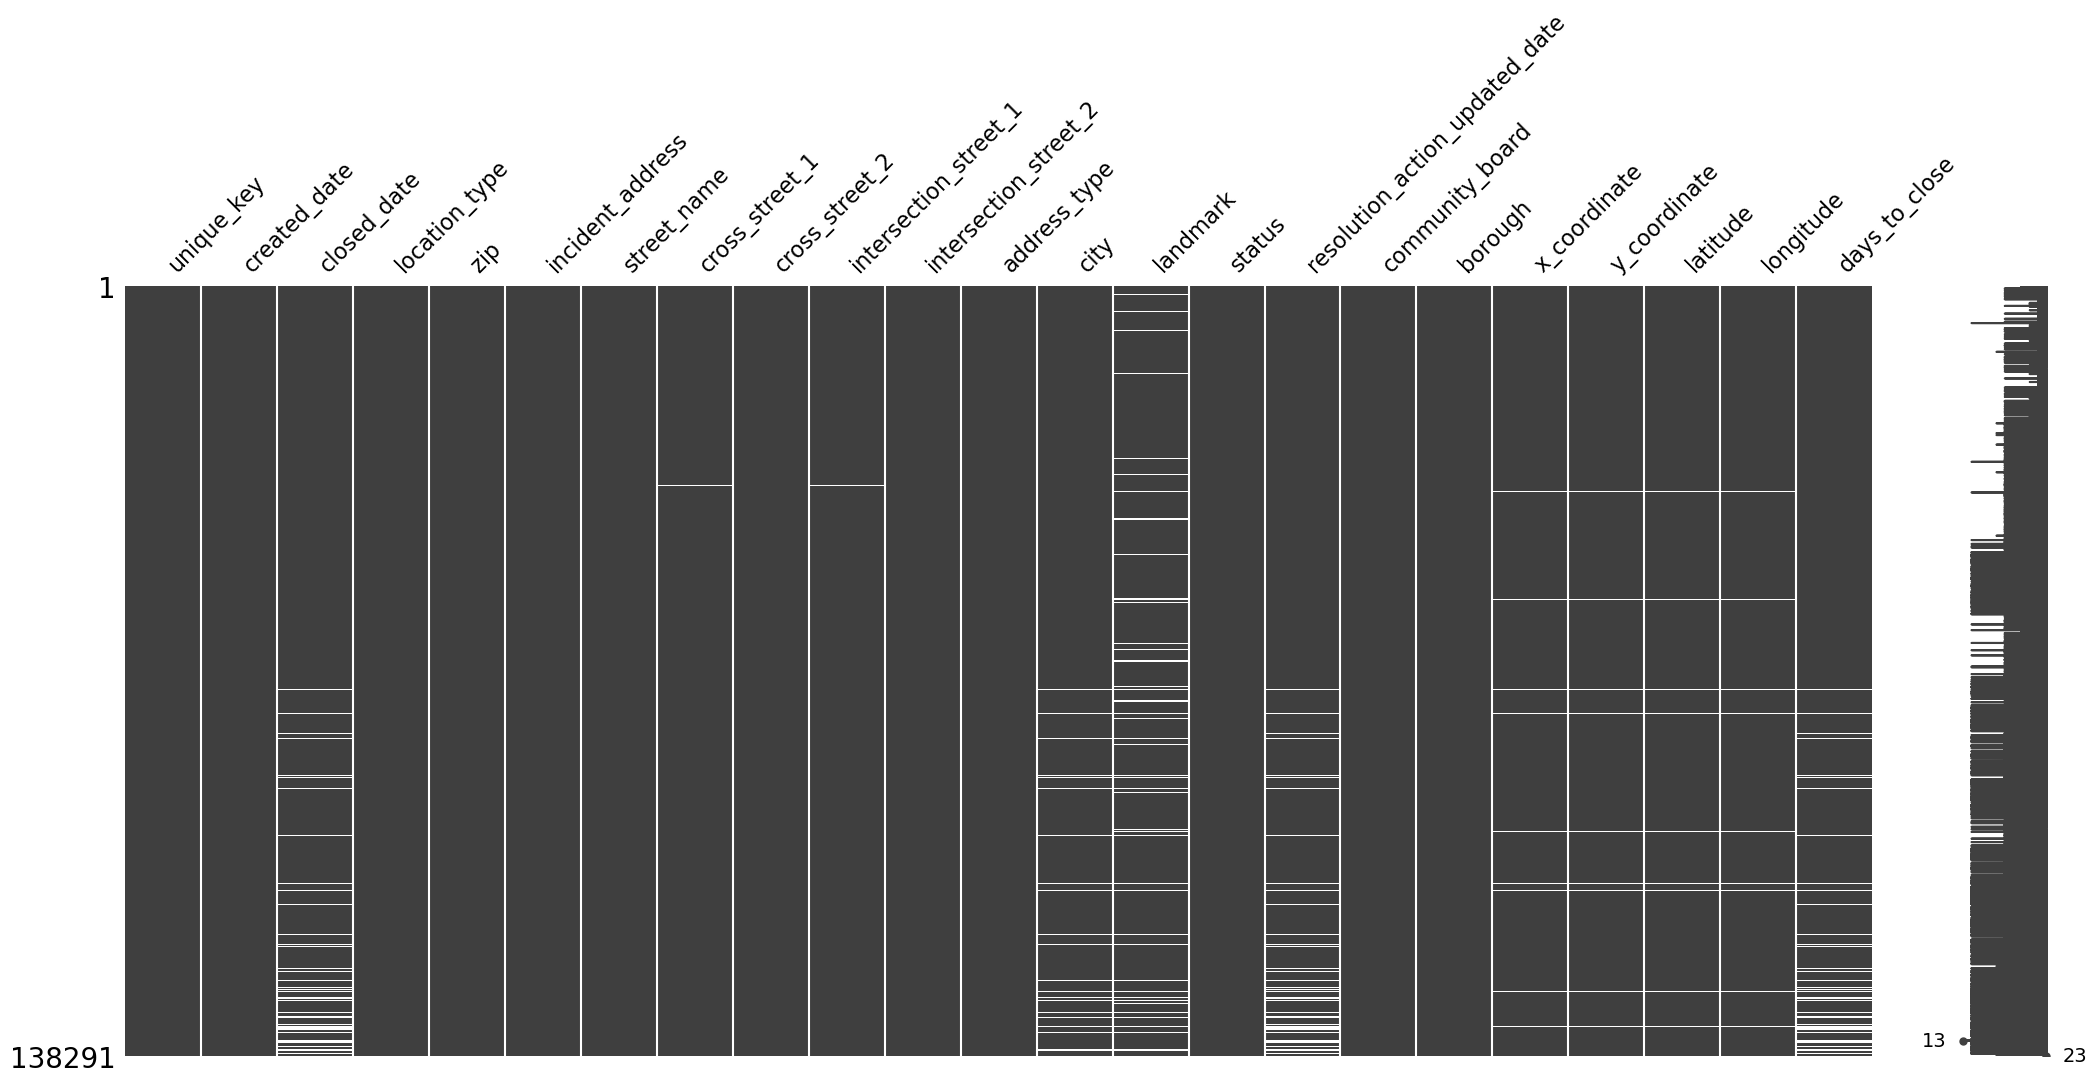

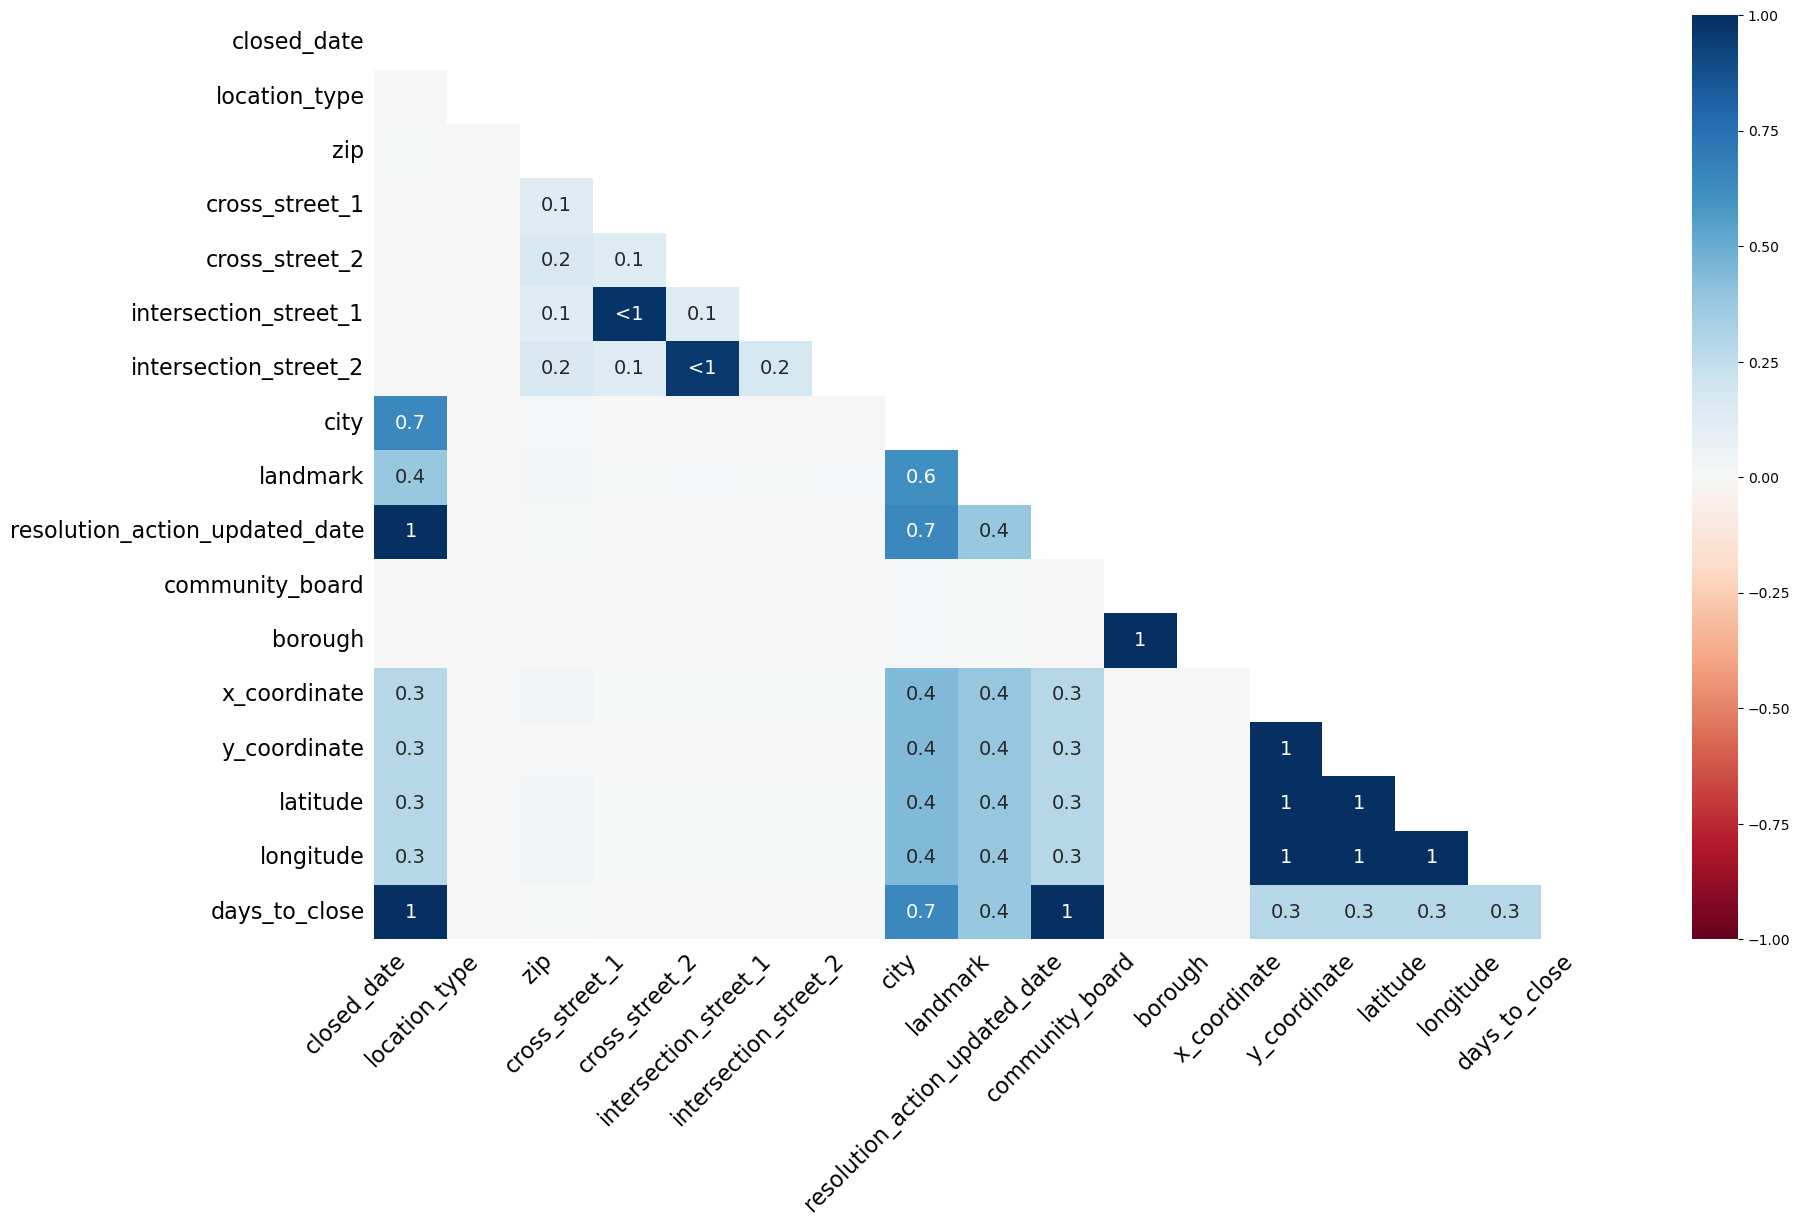

In [30]:
# We check missingness of the data.

msno.matrix(rat_sighting)
msno.heatmap(rat_sighting)

In [31]:
daily_by_borough_rat_sighting = rat_sighting.groupby([rat_sighting['created_date'].dt.date, 'borough']).size().reset_index(name='count')

daily_by_borough_rat_sighting.to_csv("../data/cleaned_rat_sightings_data/daily_borough_rs.csv", index=False)



In [32]:
daily_by_ZIP_rat_sighting = rat_sighting.groupby([rat_sighting['created_date'].dt.date, 'zip']).size().reset_index(name='count')

daily_by_ZIP_rat_sighting.to_csv("../data/cleaned_rat_sightings_data/daily_zip_rs.csv", index=False)


In [33]:
weekly_by_borough_rat_sighting = rat_sighting.groupby(
    [rat_sighting['created_date'].dt.to_period('W'), 'borough']
).size().reset_index(name='count')

weekly_by_borough_rat_sighting.to_csv("../data/cleaned_rat_sightings_data/weekly_borough_rs.csv", index=False)



In [34]:
weekly_by_ZIP_rat_sighting = rat_sighting.groupby(
    [rat_sighting['created_date'].dt.to_period('W'), 'zip']
).size().reset_index(name='count')

weekly_by_ZIP_rat_sighting.to_csv("../data/cleaned_rat_sightings_data/weekly_zip_rs.csv", index=False)


In [35]:
monthly_by_borough_rat_sighting = rat_sighting.groupby(
    [rat_sighting['created_date'].dt.to_period('M'), 'borough']
).size().reset_index(name='count')

monthly_by_borough_rat_sighting

monthly_by_borough_rat_sighting.to_csv("../data/cleaned_rat_sightings_data/monthly_borough_rs.csv", index=False)


In [36]:
monthly_by_ZIP_rat_sighting = rat_sighting.groupby(
    [rat_sighting['created_date'].dt.to_period('M'), 'zip']
).size().reset_index(name='count')

monthly_by_ZIP_rat_sighting.to_csv("../data/cleaned_rat_sightings_data/monthly_zip_rs.csv", index=False)
